# Glioma classification

## Code

This code was modified based on: https://github.com/Project-MONAI/GliMR_workshop, you may explore more there. It demonstrates classification of gliomas with MONAI using deep learning models.

## Dataset

The dataset used here is the Decathlon 3D brain tumor dataset. Here, a 2D dataset (to accelerate training) is generated by combining slices containing tumour, and those containing no tumourous voxels (considered healthy). We'll download the pre-computed dataset from Google Drive, but the script is available in case you're interested.

## Structure

1. Check if MONAI and other dependencies are installed (if not, installs them)
2. Import dependencies
3. Setup data
4. Prepare for training -- create transforms, datasets, and dataloaders
5. Display some examples
6. Create the model, loss function, and optimizer
7. Train the model
8. Visualize Loss, Accuracy, Confusion Matrix, ROC, Precesion, Recall, and F1 Score
9. Test the model with some examples

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/GliMR_workshop/blob/main/01_classification/01_glioma_classification.ipynb)

## 1.  Check if MONAI and other dependencies are installed (if not, installs them)

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import gdown" || pip install -q "gdown"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 88.0 MB/s eta 0:00:00


## 2. Import dependencies

In [2]:
# Copyright 2022 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile
import torch
from tqdm import tqdm, trange
import time
import datetime

import monai
from monai.apps import download_and_extract
from monai.data import CacheDataset, DataLoader, pad_list_data_collate, partition_dataset
from monai.networks import eval_mode
import monai.transforms as mt
from monai.utils import set_determinism
monai.config.print_config()

MONAI version: 1.5.dev2516
Numpy version: 2.0.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 875aa3d53281b83a205442db83ac41ddf817ef9a
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.14.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.51.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io

In [3]:
# Use GPU if possible, else CPU (not recommended)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set deterministic training for reproducibility
set_determinism(seed=42)

cuda


In [4]:
# figure out if we're running in Google Colab. Set paths accordingly.
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    best_model_folder = "/content/drive/MyDrive/saved_models/"
    os.makedirs(best_model_folder, exist_ok=True)
except:
    best_model_folder = ""

Mounted at /content/drive


## 3. Setup data

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable. This allows you to save results and reuse downloads. If not specified a temporary directory will be used.
We'll download the pre-computed 2D dataset from Google Drive, but the script is available in case you're interested.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else os.path.expanduser(directory)
print(root_dir)

/tmp/tmp775qvffv


In [6]:
download_from_gdrive = True
task = "Task01_BrainTumour"
output_dir = os.path.join(root_dir, task + "2D")

if download_from_gdrive:
    resource = "https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E&export=download"
    md5 = "214a338a26778c84ddebca29822add56"
    compressed_file = os.path.join(root_dir, task + "2D.tar")
    download_and_extract(resource, compressed_file, root_dir, hash_val=md5)
else:
    %run -i ../utils/2d_slice_creator.py --path {output_dir} --download_path {root_dir} --task {task}
    pass

# get all the 2d images
images_healthy = glob(os.path.join(output_dir, "image_healthy", "*.nii.gz"))
images_tumour = glob(os.path.join(output_dir, "image_tumour", "*.nii.gz"))
data_dicts = []
data_dicts += [{"image": i, "label": [1, 0]} for i in images_healthy]
data_dicts += [{"image": i, "label": [0, 1]} for i in images_tumour]

# shuffle the data and sort into training and validation
train_files, val_files = partition_dataset(data_dicts, ratios=(8, 2), shuffle=True)
print("Total No. of image sets:", len(data_dicts))
print("No. of healthy image sets:", len(images_healthy))
print("No. of healthy image sets:", len(images_tumour))
print("No. of training image sets:", len(train_files))
print("No. of validation image sets:", len(val_files))

Downloading...
From (original): https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E
From (redirected): https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E&confirm=t&uuid=63e9233c-fb44-493d-bca6-640c4d7549d7
To: /tmp/tmpty0663oo/Task01_BrainTumour2D.tar
100%|██████████| 122M/122M [00:03<00:00, 37.7MB/s]

2025-04-23 15:53:46,745 - INFO - Downloaded: /tmp/tmp775qvffv/Task01_BrainTumour2D.tar


2025-04-23 15:53:46,969 - INFO - Verified 'Task01_BrainTumour2D.tar', md5: 214a338a26778c84ddebca29822add56.
2025-04-23 15:53:46,969 - INFO - Writing into directory: /tmp/tmp775qvffv.
Total No. of image sets: 968
No. of healthy image sets: 484
No. of healthy image sets: 484
No. of training image sets: 774
No. of validation image sets: 194


## 4. Prepare for training -- create transforms, datasets, and dataloaders

### Transforms

In terms of transforms, we first load both the image and its corresponding label. We then rotate by 90 degrees, crop out superfluous zeros around the edge of the images, scale the image between 0 and 1 and then convert from numpy to pytorch.

In MONAI, we have two forms of transforms -- those that act on arrays of data, and those that act on dictionaries of data. For classification tasks, both are acceptable. We've used dictionaries here (note the `d` suffix in our transform names) –– such that each image and its corresponding class are stored together.

### Datasets and dataloaders

We use the `CacheDataset` which accelerates things by pre-computing the results of our deterministic transforms. We then use a batch size of 10 in our dataloader.

In [7]:
train_transforms = val_transforms = mt.Compose(
    [
        mt.LoadImaged("image"),
        mt.Rotate90d("image"),
        mt.CropForegroundd("image", source_key="image", k_divisible=16),
        mt.ScaleIntensityd("image", channel_wise=True),
        mt.EnsureTyped(["image", "label"]),
    ]
)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [8]:
# The cache dataset loads in our images and keeps them in the RAM to save time on each loop.
# We use the pad_list_data_collate so that all images in our batch of data are the same size.
num_workers = 2
train_ds = CacheDataset(
    data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=10,
                          num_workers=num_workers, collate_fn=pad_list_data_collate)
val_ds = CacheDataset(
    data=val_files, transform=train_transforms, cache_rate=1.0, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=10,
                        num_workers=num_workers, collate_fn=pad_list_data_collate)

Loading dataset: 100%|██████████| 194/194 [00:02<00:00, 76.48it/s]


## 5. Display some examples

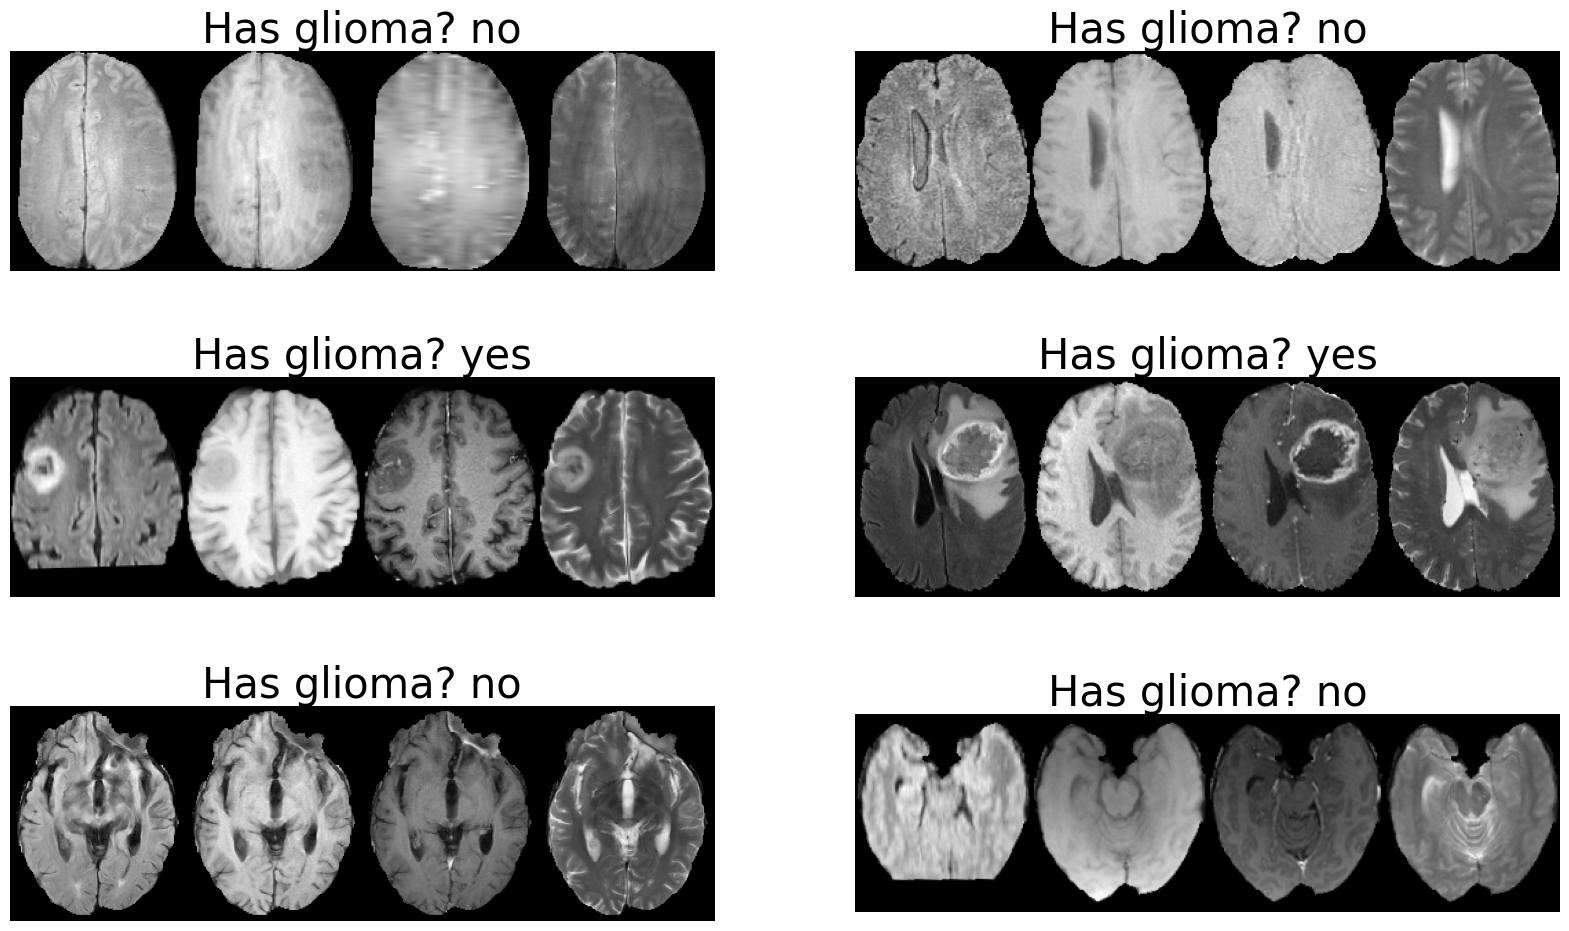

In [9]:
nrow, ncol = 3, 2
num_files = nrow * ncol
files_to_visualize = np.random.choice(train_files, size=num_files, replace=False)
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 12), facecolor='white')
for f, ax in zip(files_to_visualize, axes.flatten()):
    data = train_transforms(f)
    # different sequences side by side
    img = np.concatenate(list(data["image"]), axis=1)
    im_show = ax.imshow(img, cmap="gray")
    ax.set_title(f"Has glioma? {['yes', 'no'][data['label'][0]]}",fontsize = 30)
    ax.axis("off")

## 6. Create the model, loss function, and optimizer

In [32]:
# Create model
model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=4, out_channels=2)
model.to(device)

# Define loss function
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

# # Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 7. Train the model



In [33]:
# start training
max_epochs = 30
val_interval = 1
best_accuracy = -1
best_accuracy_epoch = -1

train_losses = []
train_accs = []
val_losses = []
val_accs = []
tr = trange(max_epochs)
start_time = time.time()
for epoch in tr:

    epoch_loss = 0
    train_total = 0
    train_correct = 0
    for batch_data in train_loader:
        inputs, labels = batch_data["image"], batch_data["label"]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs_sm = torch.nn.Softmax(dim=1)(outputs)
        # check loss and accuracy
        loss = loss_function(outputs_sm, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        correct = torch.eq(outputs.argmax(dim=1), labels.argmax(dim=1))
        train_total += labels.size(0)
        train_correct += int(correct.sum().item())

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct / train_total
    train_accs.append(train_acc)

    if (epoch + 1) % val_interval == 0:
        with eval_mode(model):
            epoch_loss = 0
            val_total = 0
            val_correct = 0
            for val_data in val_loader:
                val_images, val_labels = val_data["image"], val_data["label"]
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                with torch.no_grad():
                    val_outputs = model(val_images)
                    val_outputs_sm = torch.nn.Softmax(dim=1)(val_outputs)
                    # check loss and accuracy
                    loss = loss_function(val_outputs_sm, val_labels.float())
                    epoch_loss += loss.item()
                    correct = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                    val_total += val_labels.size(0)
                    val_correct += int(correct.sum().item())

            val_loss = epoch_loss / len(val_loader)
            val_losses.append(val_loss)
            val_acc = val_correct / val_total
            val_accs.append(val_acc)

            # If better than current best, save model
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_accuracy_epoch = epoch + 1
                current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
                best_model_path = os.path.join(best_model_folder, f"best_model_glioma_classification_{current_time}.pth")

    tr.set_description(f"Epoch: {epoch + 1}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Train acc: {train_acc:.4f}, Val acc: {val_acc:.4f}")
end_time = time.time()
elapsed_time = end_time - start_time
torch.save(model.state_dict(), best_model_path)
print(f"\nBest accuracy: {best_accuracy} at epoch {best_accuracy_epoch}")
print(f"Training time: {elapsed_time} seconds")

Epoch: 30, Train loss: 0.3458, Val loss: 0.3532, Train acc: 0.9690, Val acc: 0.9588: 100%|██████████| 30/30 [07:13<00:00, 14.46s/it]


Best accuracy: 0.9948453608247423 at epoch 18
Training time: 433.7724778652191 seconds


# 8. Visualize Loss, Accuracy, Confusion Matrix, ROC, Precesion, Recall, and F1 Score

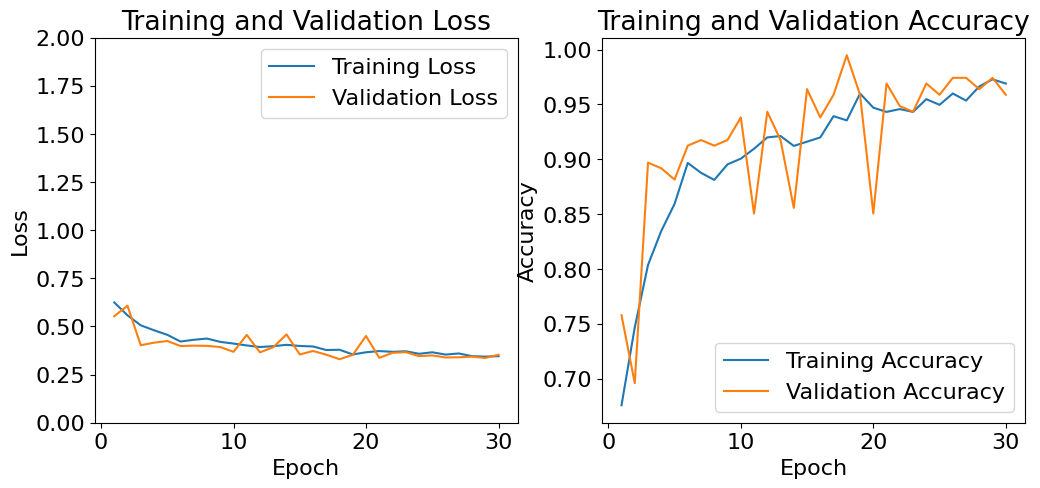

In [34]:
# Visualize Loss and Accuracy

# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, max_epochs+1), val_losses, label='Validation Loss')
plt.ylim(0, 2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs+1), train_accs, label='Training Accuracy')
plt.plot(range(1, max_epochs+1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [35]:
# Load the best model for evaluation
model.load_state_dict(torch.load(best_model_path))
_ = model.eval()

In [36]:
# Use the validation dataset for evaluation (Or you can leave a test dataset for evaluation during data preparation)
y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)

for data in tqdm(val_loader):
    images, labels = data["image"].to(device), data["label"].to(device)
    outputs = model(images).detach()
    y_pred = torch.cat([y_pred, outputs], dim=0)
    y = torch.cat([y, labels], dim=0)

y_pred = y_pred.argmax(dim=1)
y = y.argmax(dim=1)

100%|██████████| 20/20 [00:02<00:00,  9.76it/s]


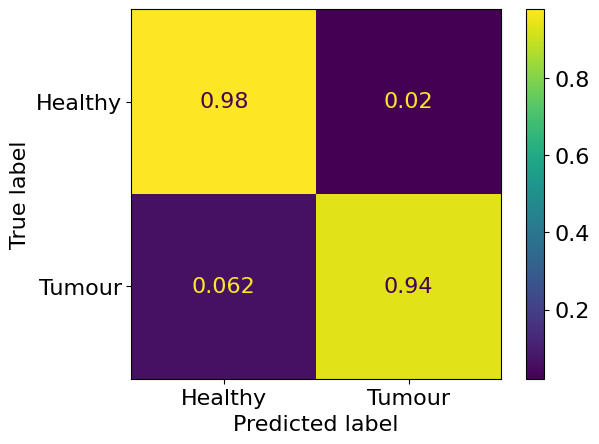

In [37]:
# Visualize Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Healthy", "Tumour"],
)
_ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

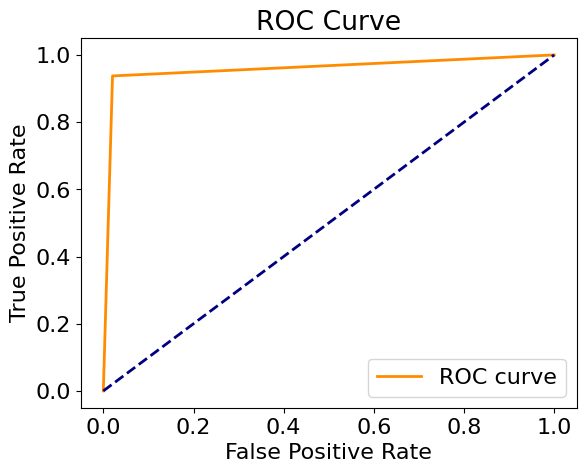

In [38]:
# Visualize ROC Curve
from sklearn.metrics import roc_curve

# Calculate fpr and tpr
fpr, tpr, _ = roc_curve(y.cpu().numpy(), y_pred.cpu().numpy())
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

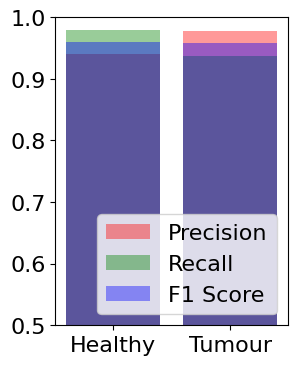

In [39]:
# Visualize Precision, Recall and F1 Score
from sklearn.metrics import precision_recall_fscore_support

# Calculate the precision, recall, and F1 scores
precision, recall, f1_score, _ = precision_recall_fscore_support(y.cpu().numpy(), y_pred.cpu().numpy(), average=None)

# Define the labels for the two classes
plt.rcParams.update({'font.size': 16})
labels = ["Healthy", "Tumour"]

# Plot the precision, recall, and F1 scores
plt.figure(figsize=(3, 4))
plt.bar(labels, precision, color='r', alpha=0.4, label='Precision')
plt.bar(labels, recall, color='g', alpha=0.4, label='Recall')
plt.bar(labels, f1_score, color='b', alpha=0.4, label='F1 Score')
plt.ylim(0.5, 1)
plt.legend(loc='lower right') # place legend outside the figure
plt.show()

# 9. Test the model with some examples

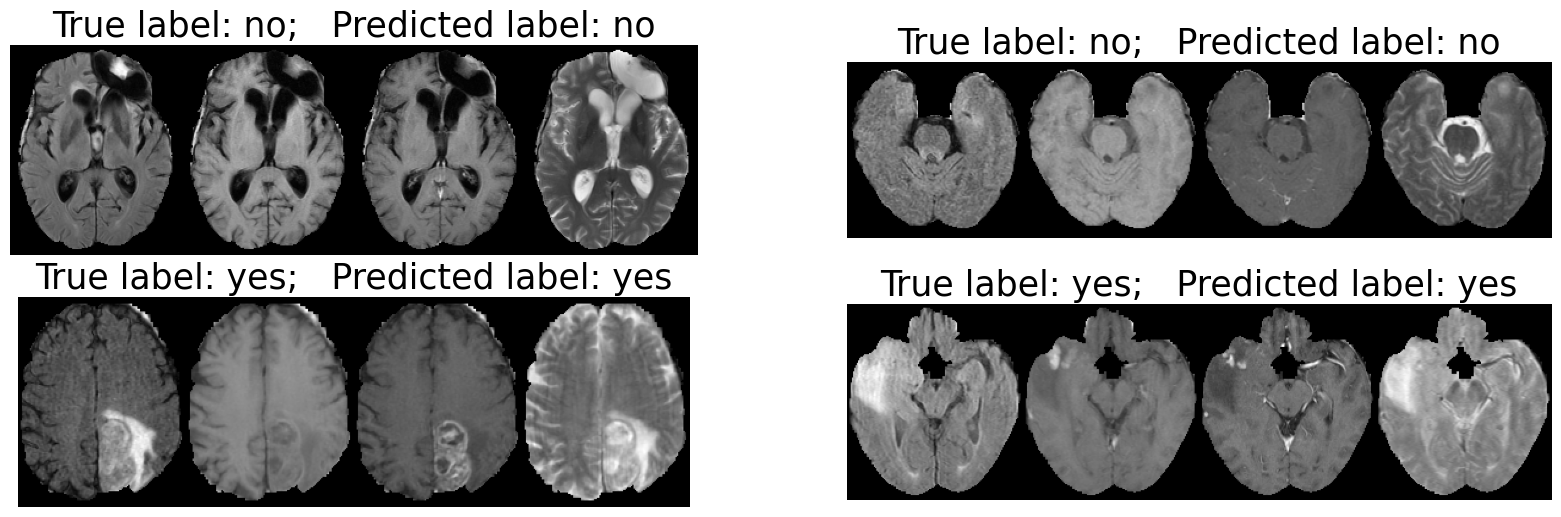

In [40]:
nrow, ncol = 2, 2
num_files = nrow * ncol
files_to_visualize = np.random.choice(val_files, size=num_files, replace=False)
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 6), facecolor='white')
for f, ax in zip(files_to_visualize, axes.flatten()):
    test_data = train_transforms(f)
    test_images, test_labels = test_data["image"], test_data["label"]
    test_images, test_labels = test_images.to(device).unsqueeze(0), test_labels.to(device).unsqueeze(0)
    with torch.no_grad():
      test_outputs = model(test_images)
      test_outputs = 1-torch.nn.Softmax(dim=1)(test_outputs).argmax(dim=1)
      # different modalities side by side
      img = np.concatenate(list(test_data["image"]), axis=1)
      im_show = ax.imshow(img, cmap="gray")
      ax.set_title(f"True label: {['yes', 'no'][test_data['label'][0]]};   Predicted label: {['yes', 'no'][test_outputs]}",fontsize = 25)
      ax.axis("off")